<a href="https://colab.research.google.com/github/AlmTechSoftware/piper/blob/main/training_data/research/feynman_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!curl http://0x0.st/HLtv.zip > dataset.zip
!rm -r dataset
!unzip dataset.zip -d dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12.1M  100 12.1M    0     0  4595k      0  0:00:02  0:00:02 --:--:-- 4593k
Archive:  dataset.zip
 extracting: dataset/README.dataset.txt  
 extracting: dataset/README.roboflow.txt  
   creating: dataset/test/
 extracting: dataset/test/Adam-still_jpeg.rf.90fbaea30ed3e09fd7fda5aa92ea6a68.jpg  
 extracting: dataset/test/Adam-still_jpeg.rf.90fbaea30ed3e09fd7fda5aa92ea6a68_mask.png  
 extracting: dataset/test/Board_jpg.rf.4d5d6a6f3c89eab87661fa09120877ef.jpg  
 extracting: dataset/test/Board_jpg.rf.4d5d6a6f3c89eab87661fa09120877ef_mask.png  
 extracting: dataset/test/MPC_2_jpg.rf.8263fb9cbb0b86857de4519a380ac872.jpg  
 extracting: dataset/test/MPC_2_jpg.rf.8263fb9cbb0b86857de4519a380ac872_mask.png  
 extracting: dataset/test/_classes.csv  
 extracting: dataset/test/falling_mp4-4_jpg.rf.6ae094b71ea51930490457b2e4125171.jpg  
 extrac

In [2]:
!pip install  opencv-python \
              scikit-image \
              python-dotenv \
              pycocotools \
              dataclasses-json \
              supervision \
              colored \
              wandb \
              torchvision -Uq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 22.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.8 MB/s eta 0:00:00


## WandB login

In [3]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Dataset Handler Definition

In [48]:
import os
from typing import Tuple
import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision import transforms

from PIL import Image
from matplotlib import cm

from glob import glob

class PNGMaskDataset(Dataset):
    def __init__(
        self,
        dataset_dir: str,
    ):
        self.dataset_dir = dataset_dir
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
            ]
        )

        # Example _classes.csv
        """
        Pixel Value, Class
        0, background
        1, sghug
        2, w%
        """

        # Parse _classes.csv
        fh = open(os.path.join(self.dataset_dir, "_classes.csv"))
        lines = fh.readlines()
        fh.close()

        self.classes = map(lambda csv: csv.split(", "), lines)
        self.classes = map(lambda csv: (csv[1], int(csv[0])), self.classes)


        # Load images & masks
        self.mask_files = glob(os.path.join(self.dataset_dir, "*_mask.png"))

        all_files =  glob(os.path.join(self.dataset_dir, "*"))
        self.images = {}
        for mask_file in self.mask_files:
            img_file = mask_file.replace("_mask.png", ".jpg")
            base, ext = os.path.splitext(img_file)

            if img_file in all_files:
                self.images[base] = {
                    "image": img_file,
                    "mask": mask_file,
                }

    def __str__(self):
        return str(self.images)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_info = list(self.images.values())[idx]

        # Load and preprocess the image
        image_path = image_info["image"]
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)

        # Load and preprocess the segmentation mask
        mask_path = image_info["mask"]
        mask = Image.open(mask_path).convert("RGB")
        mask = self.transform(mask)
        mask = mask * 255

        return image, mask

In [49]:
import torchvision.transforms as T
_tensor_pil_transform = T.ToPILImage()

def tensor_to_pil(tensor: torch.Tensor):
    return _tensor_pil_transform(tensor)

### Example

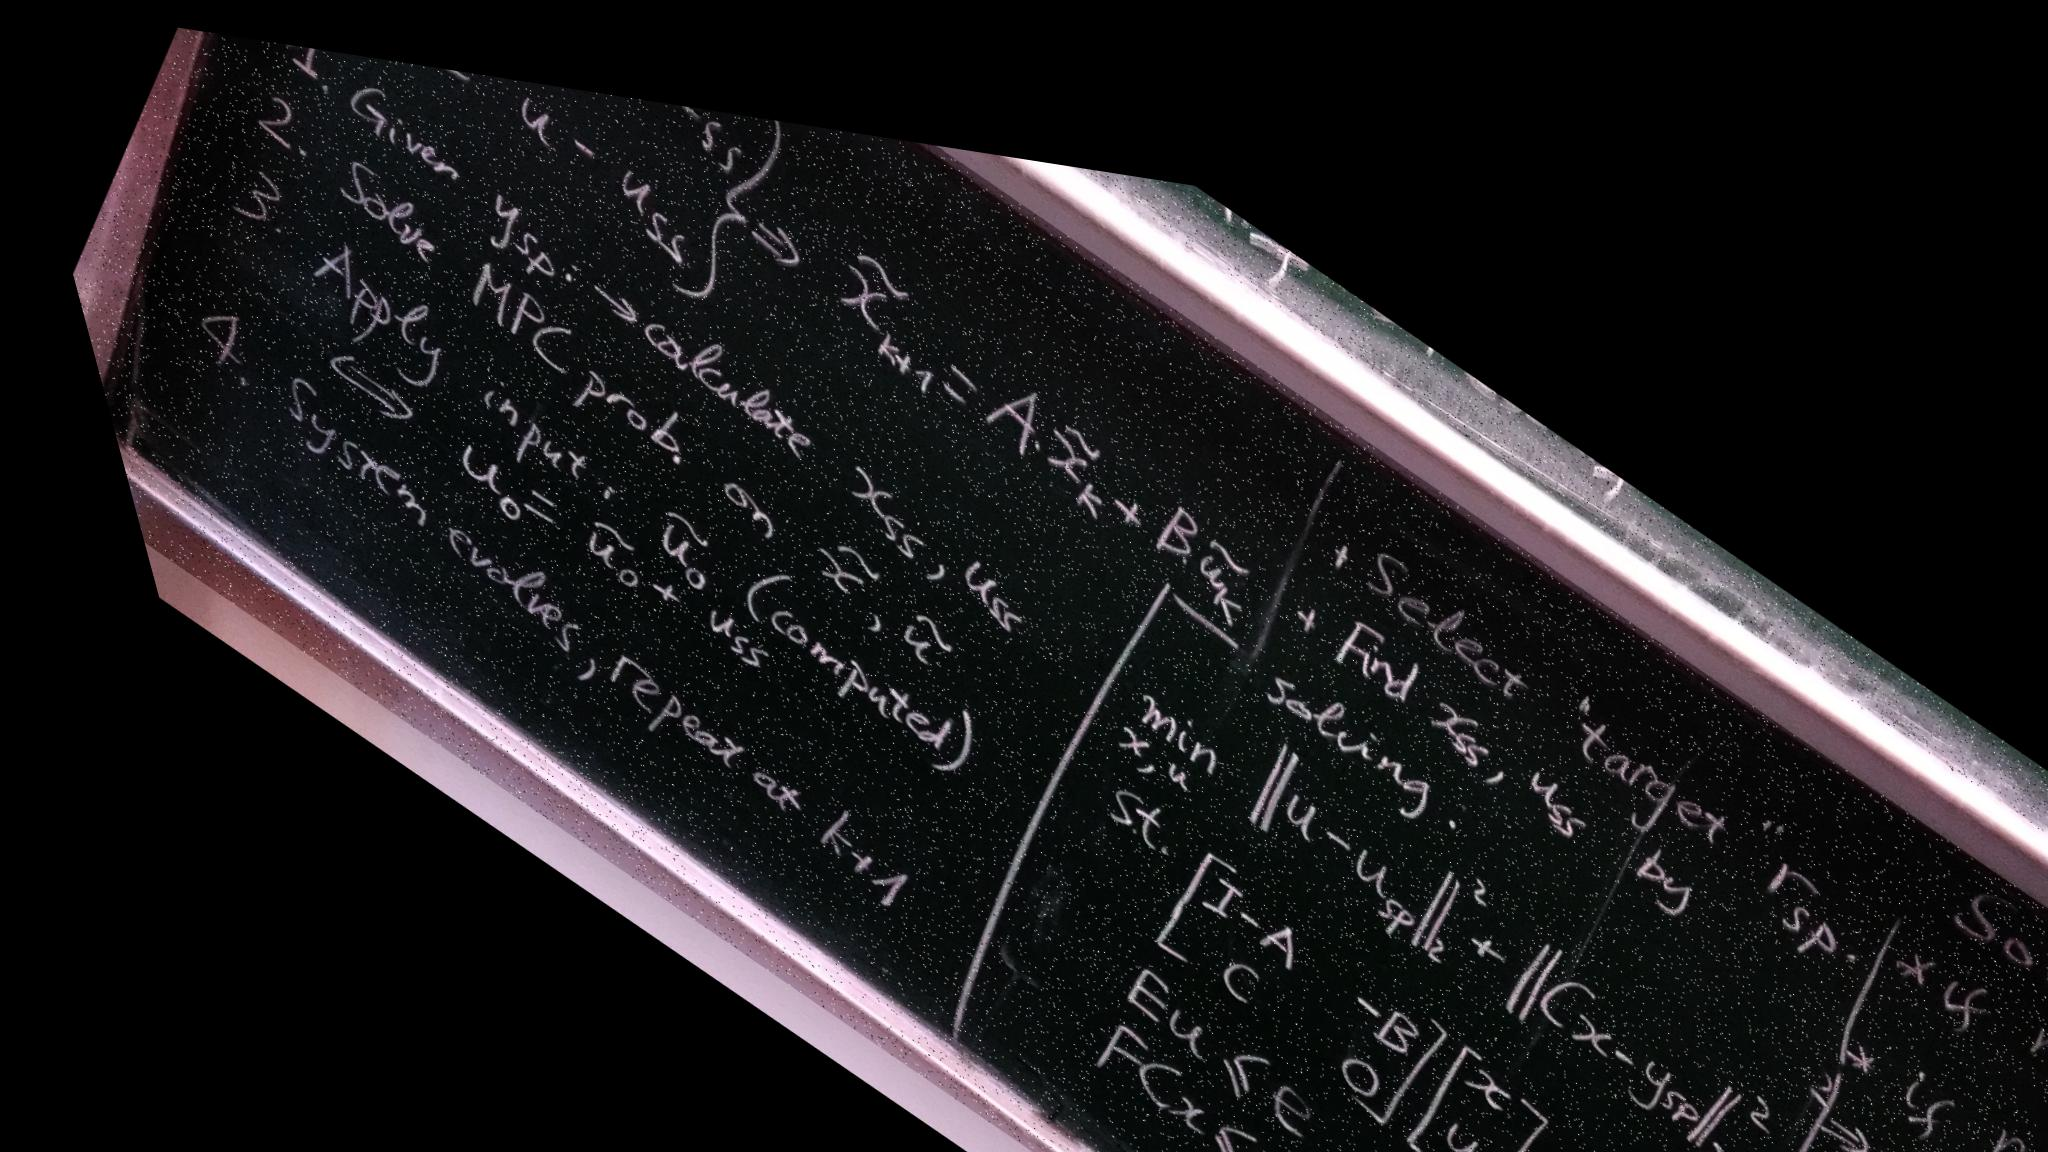

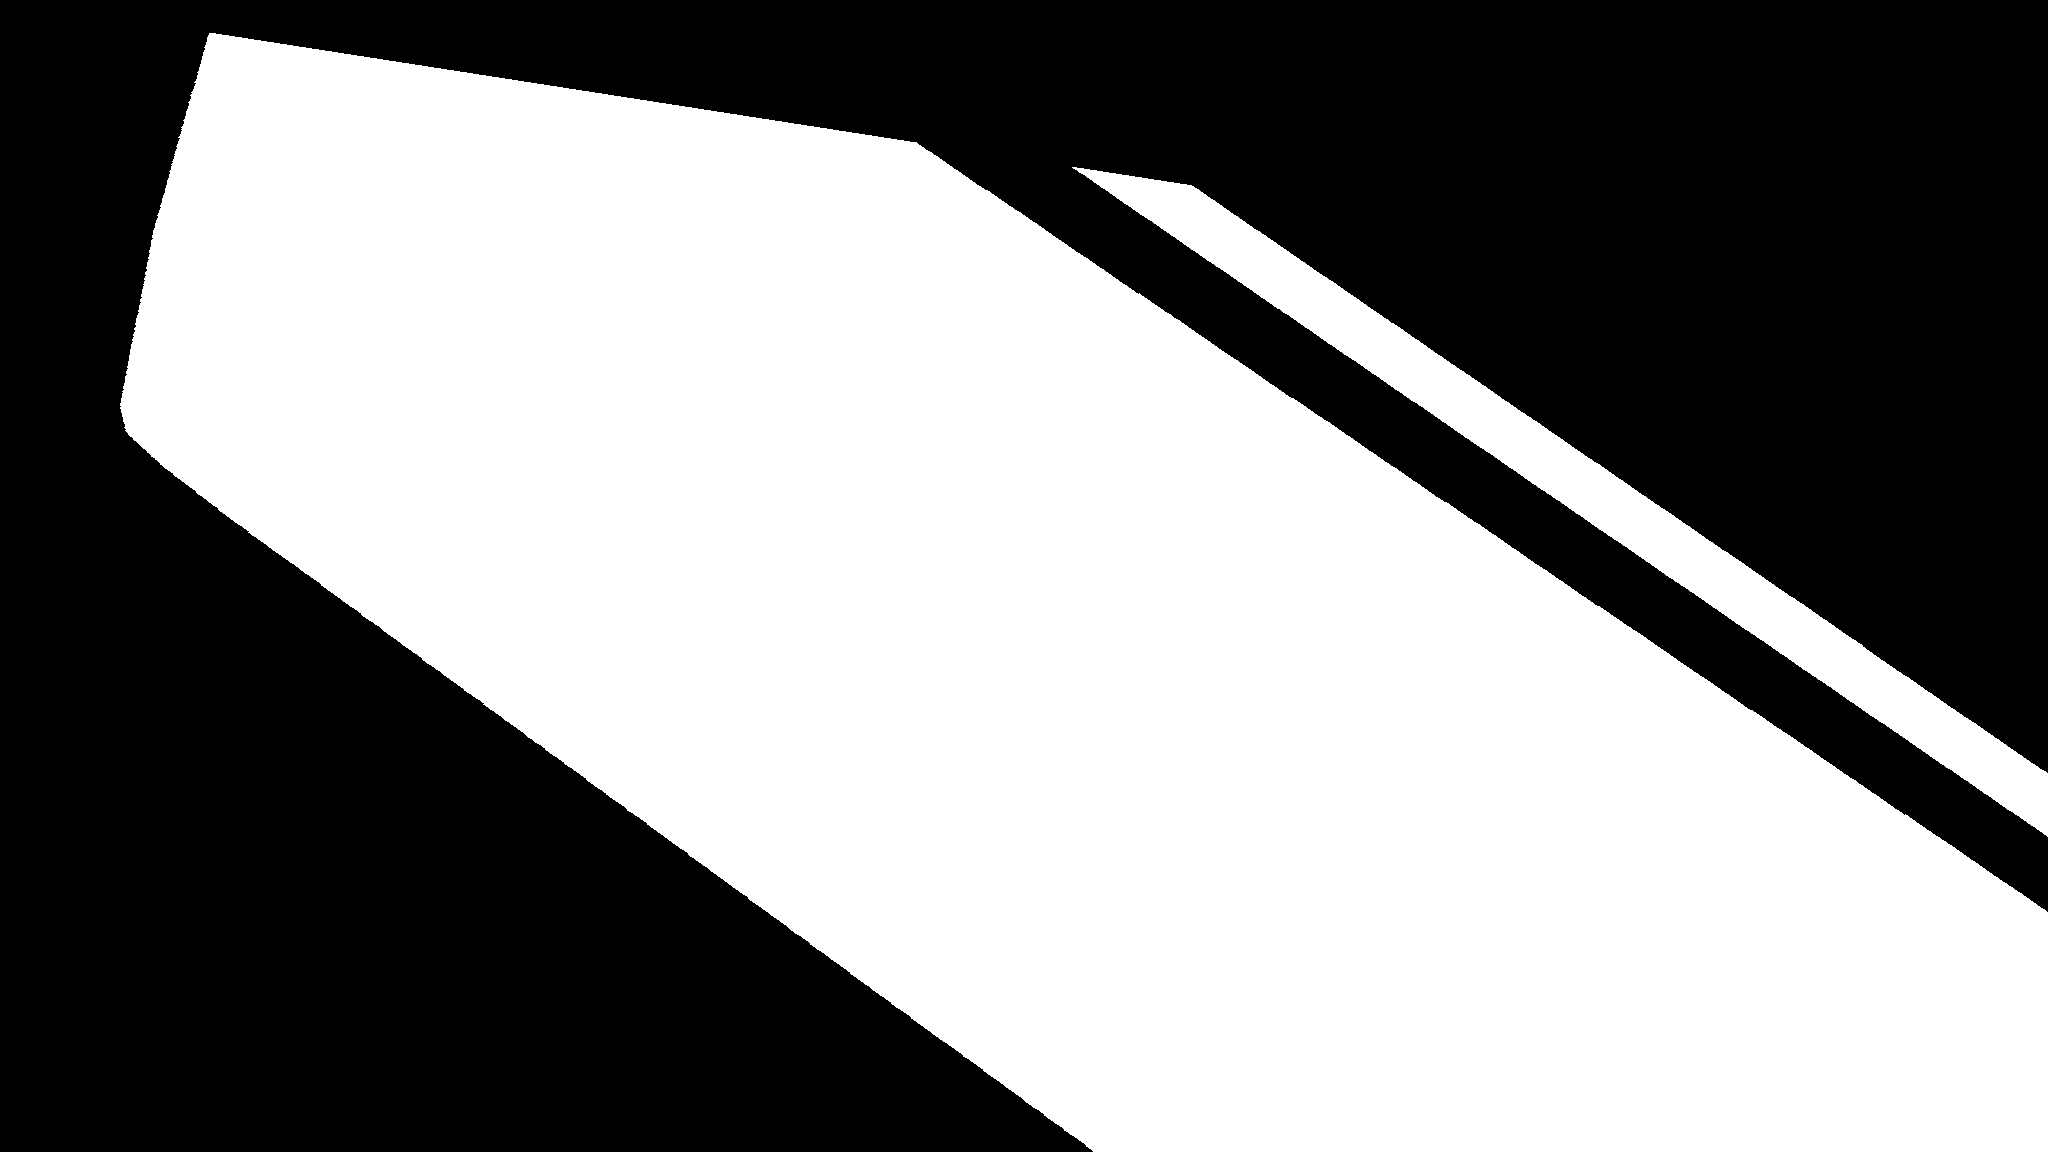

In [50]:
dataset = PNGMaskDataset("dataset/train")

img, mask = dataset[2]

img = tensor_to_pil(img)
mask = tensor_to_pil(mask)

display(img)
display(mask)